# Machine Learning for Wind Power Forecasting

This notebook implements multiple models for wind power forecasting. The first uses a one-step model based on a Random Forest (RF) regressor that predicts the wind power at the next time step based on a past hour of power outputs. The second uses a multi-step (recursive autoregressive) model to predict an hour ahead in 10min increments based on a past hour of power outputs. The results show that high autocorrelation of wind power results in an autoregressive model that performs slightly better with a linear regressor than it does with RF.  

In [2]:
import os

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from albatross.analysis import plot_windrose, boxplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import seaborn as sns

from REStats.utils import load_SCADA

In [3]:
# cmap = mpl.colormaps['tab10']
sns.set_theme()

## Data

The data consists of two years (2019-2020) of Wind Turbine data from the Kelmarsh Wind Farm in the UK.

Plumley, Charlie. Kelmarsh Wind Farm Data. Zenodo, 1 Feb. 2022. Zenodo, https://doi.org/10.5281/zenodo.5841834.


In [4]:
wt_raw = load_SCADA(2020)
wt = wt_raw.copy()

wt = wt.dropna()

In [12]:
wt.describe()

,Power,Wind direction,Wind speed
count,52236.000000,52236.000000,52236.000000
mean,716.467207,197.940539,6.524402
std,680.552771,91.136738,3.011010
min,-16.487485,0.014923,0.258319
25%,133.568163,142.185515,4.313493
50%,483.312851,217.529350,6.225888
75%,1194.308194,258.124086,8.311649
max,2078.528772,359.962357,22.419562


In [13]:
# ensure no null values
len(wt[wt["Power"].isnull()]) == 0

True

In [14]:
speed = wt.loc[:, "Wind speed"]
direction = wt.loc[:, "Wind direction"]
active_power = wt.loc[:, "Power"]

The wind speed distribution represents a typical right-skewed distribution, where we see the highest counts around 5-6 m/s

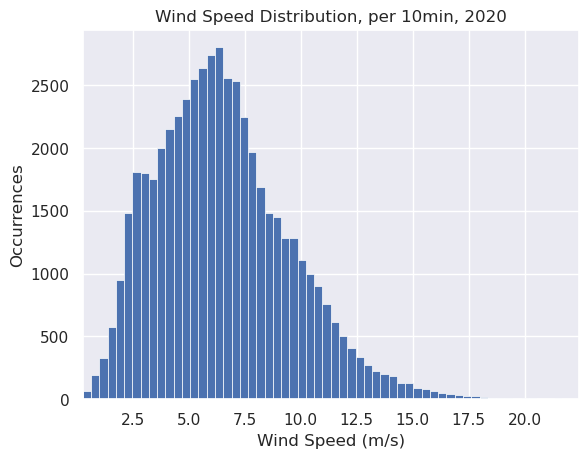

In [15]:
fig, ax = plt.subplots()

ax.set_title("Wind Speed Distribution, per 10min, 2020")
ax.set_xlabel("Wind Speed (m/s)")
ax.set_ylabel("Occurrences")
ax.set_xmargin(0)
ax.hist(speed, 60, linewidth=0.5, edgecolor="white")
ax.grid(True)

#fig.savefig("ws_distribution.png")

A wind rose is a useful visualization that simultaneously characterizes wind speed and wind direction. The magnitude of a spoke represents the percentage of time in that direction. In this one we see that the predominant wind direction is SW.

<WindroseAxes: >

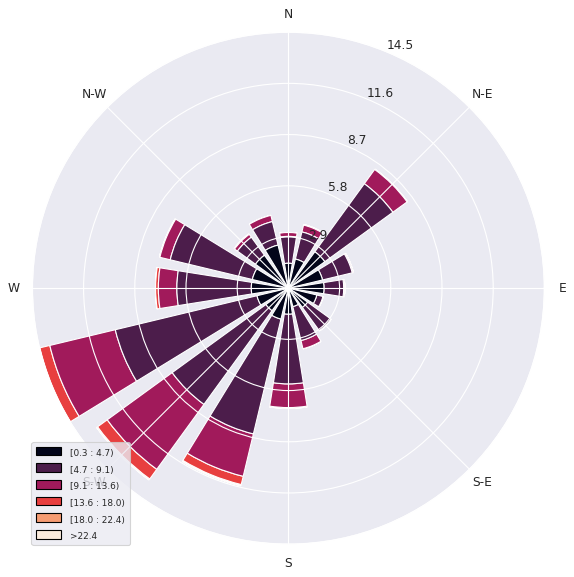

In [16]:
plot_windrose(wt, speed="Wind speed", direction="Wind direction")

We can also look at wind speed vs power output. We see that there is a strong correlation between the two, which is expected. There's an exception here in the middle of the day, where the power drops to zero. It looks like the turbine cut-in speed is around 2 m/s, meaning that it will shut off below that wind speed.

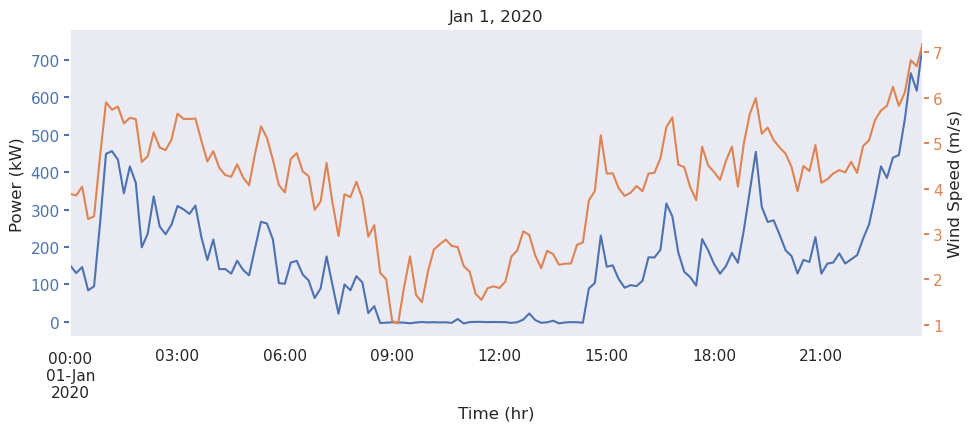

In [17]:
wt_1day = wt.loc[(wt.index >= "2020-01-01") & (wt.index < "2020-01-02")]

fig, ax = plt.subplots(figsize=(11, 4))

wt_1day["Power"].plot(ax=ax, color="C0")
right_ax = ax.twinx()
wt_1day["Wind speed"].plot(ax=right_ax, color="C1")

ax.grid(False)
right_ax.grid(False)
right_ax.axis('on')

ax.set_title("Jan 1, 2020")
ax.set_ylabel("Power (kW)")
ax.set_xmargin(0)
right_ax.set_xmargin(0)
ax.set_xlabel("Time (hr)")
ax.tick_params(axis='y', colors="C0", size=4, width=1.5)
right_ax.set_ylabel("Wind Speed (m/s)")
right_ax.tick_params(axis='y', colors="C1", size=4, width=1.5)

#fig.savefig("p_ws.png")

If we plot all of the observations of wind speed vs power, we get a representation of the turbine's power curve. As we saw before, it appears that the cut-in speed is around 2 m/s, and the rated power is around 2000 kW, or 2 MW. The turbine controls will prevent it from attempting to produce beyond that point, so the curve levels off at that power. Finally, we see that the cut-out speed is around 20 m/s, where the turbine will shut down to prevent damage from high winds.

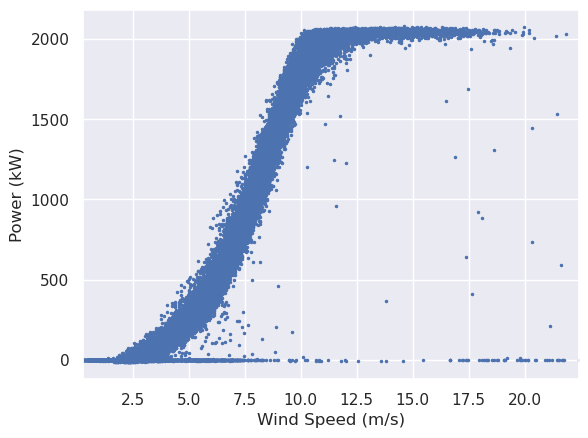

In [18]:
fig, ax = plt.subplots()
ax.plot(speed, active_power, "o", markersize=1.5)
ax.set_xlabel("Wind Speed (m/s)")
ax.set_ylabel("Power (kW)")
ax.set_xmargin(0)

# fig.savefig("power_curve.png")

This information is useful, but in order to form a forecasting model, we need to determine a feature set that incorporates an intuition about the past so that we can predict the future. One way to look at this is through autocorrelation: how does past power correlate with current power? We can explore this by calculating the correlation coefficients of current power with its past values, also called "lags". We see from the plot that current power is highly correlated with past power, up to a certain point. With this knowledge, we can attempt to build a model that uses these lags themselves as features!

/home/cam/mambaforge/envs/REStats/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


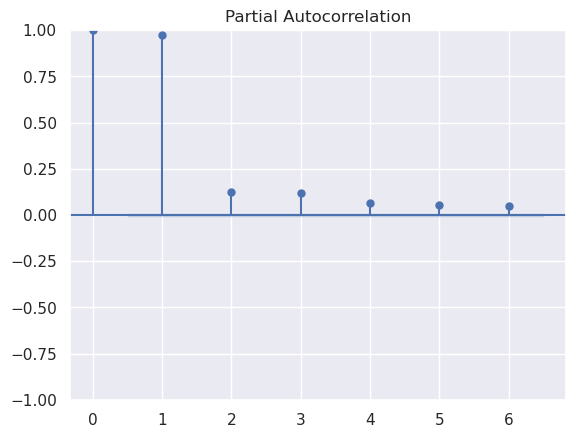

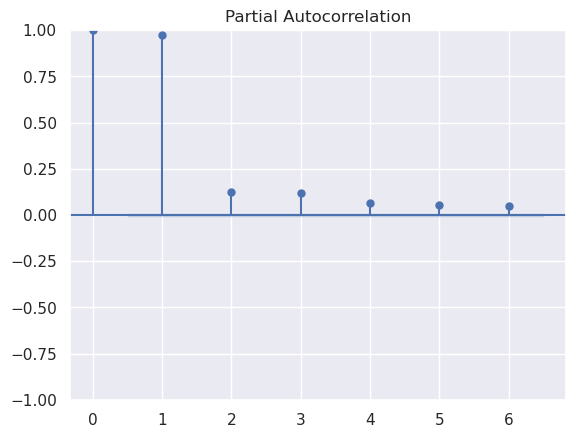

In [19]:
plot_pacf(wt["Power"], lags=6)

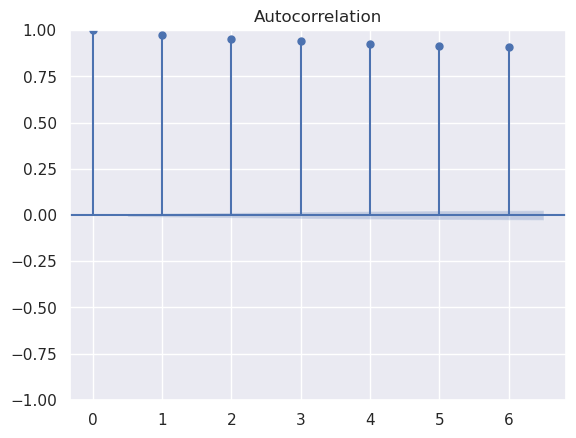

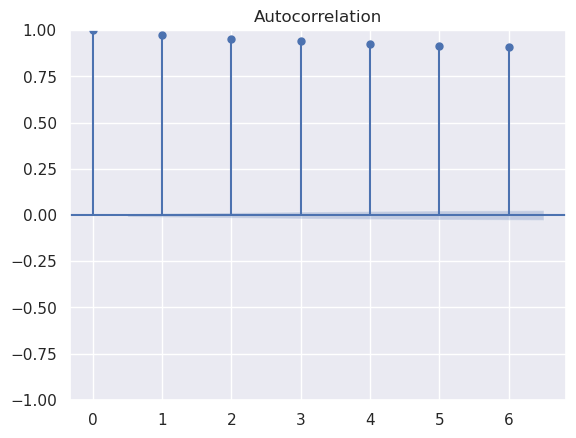

In [20]:
plot_acf(wt["Power"], lags=6)

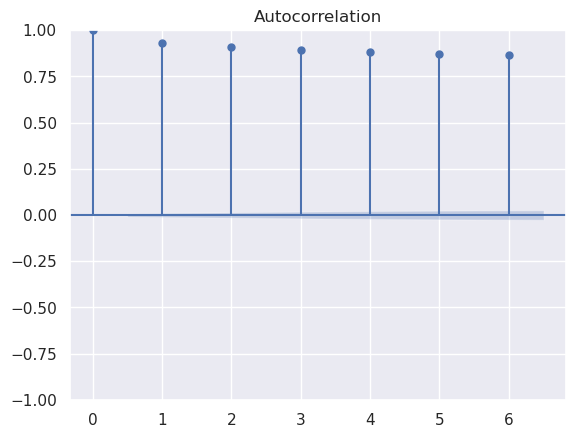

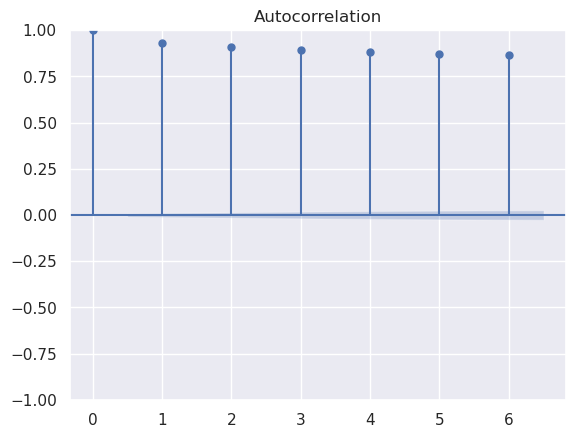

In [6]:
plot_acf(wt["Wind direction"], lags=6)

/home/cam/mambaforge/envs/REStats/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


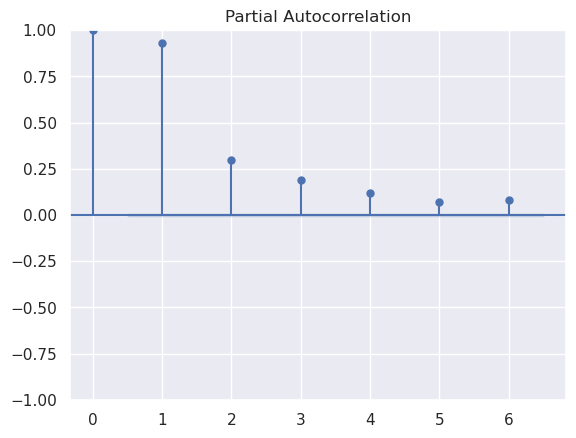

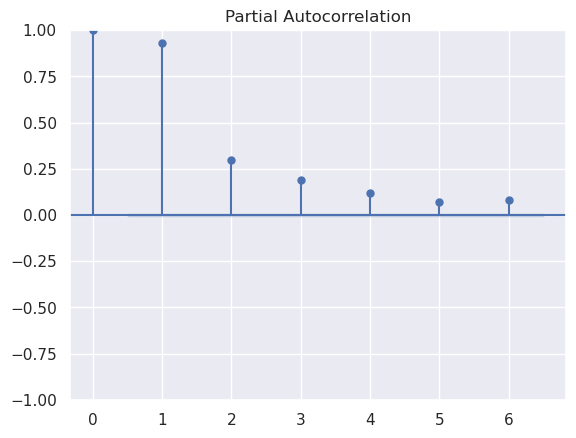

In [7]:
plot_pacf(wt["Wind direction"], lags=6)